In [ ]:
!pip install spikingjelly

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#visualize the realationship between non-linear activation RELU and IF neuron
# import torch
# from spikingjelly.activation_based import neuron
# from spikingjelly import visualizing
# from matplotlib import pyplot as plt
# import numpy as np

# plt.rcParams['figure.dpi'] = 200
# if_node = neuron.IFNode(v_reset=None)
# T = 128
# x = torch.arange(-0.2, 1.2, 0.04)
# plt.scatter(torch.arange(x.shape[0]), x)
# plt.title('Input $x_{i}$ to IF neurons')
# plt.xlabel('Neuron index $i$')
# plt.ylabel('Input $x_{i}$')
# plt.grid(linestyle='-.')
# plt.show()

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import spikingjelly
from spikingjelly.activation_based import ann2snn
from tqdm import tqdm
#from spikingjelly.activation_based.ann2snn.sample_models import mnist_cnn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the CNN model
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(32, 10)
        )


    def forward(self, x):
        x = self.network(x)
        return x


In [ ]:
def val(net, device, data_loader, T=None):
    net.eval().to(device)
    correct = 0.0
    total = 0.0
    if T is not None:
        corrects = np.zeros(T)
    with torch.no_grad():
        for batch, (img, label) in enumerate(tqdm(data_loader)):
            img = img.to(device)
            if T is None:
                out = net(img)
                correct += (out.argmax(dim=1) == label.to(device)).float().sum().item()
            else:
                for m in net.modules():
                    if hasattr(m, 'reset'):
                        m.reset()
                for t in range(T):
                    if t == 0:
                        out = net(img)
                    else:
                        out += net(img)
                    corrects[t] += (out.argmax(dim=1) == label.to(device)).float().sum().item()
            total += out.shape[0]
    return correct / total if T is None else corrects / total

100%|██████████| 200/200 [00:05<00:00, 33.51it/s]


ANN Validating Accuracy: 0.4861
---------------------------------------------
Converting using MaxNorm


100%|██████████| 600/600 [00:37<00:00, 16.20it/s]


Simulating...


100%|██████████| 200/200 [04:37<00:00,  1.39s/it]


SNN accuracy (simulation 50 time-steps): 0.4812
---------------------------------------------
Converting using RobustNorm


100%|██████████| 600/600 [00:47<00:00, 12.58it/s]


Simulating...


100%|██████████| 200/200 [04:17<00:00,  1.29s/it]


SNN accuracy (simulation 50 time-steps): 0.4814
---------------------------------------------
Converting using 1/2 max(activation) as scales...


100%|██████████| 600/600 [00:30<00:00, 19.92it/s]


Simulating...


100%|██████████| 200/200 [04:19<00:00,  1.30s/it]


SNN accuracy (simulation 50 time-steps): 0.4574
---------------------------------------------
Converting using 1/3 max(activation) as scales


100%|██████████| 600/600 [00:29<00:00, 20.20it/s]


Simulating...


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]


SNN accuracy (simulation 50 time-steps): 0.4102
---------------------------------------------
Converting using 1/4 max(activation) as scales


100%|██████████| 600/600 [00:28<00:00, 21.19it/s]


Simulating...


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]


SNN accuracy (simulation 50 time-steps): 0.3438
---------------------------------------------
Converting using 1/5 max(activation) as scales


100%|██████████| 600/600 [00:27<00:00, 21.61it/s]


Simulating...


100%|██████████| 200/200 [04:32<00:00,  1.36s/it]


SNN accuracy (simulation 50 time-steps): 0.2855


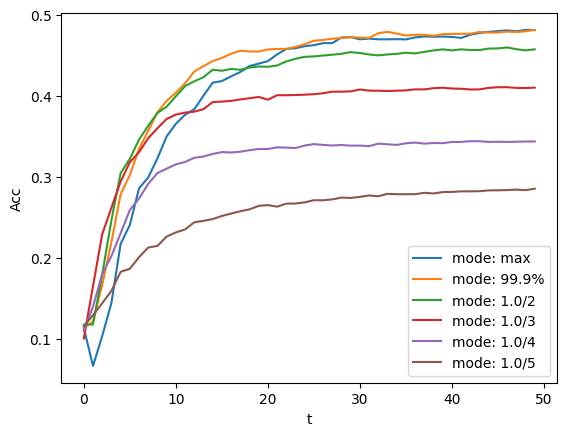

In [ ]:
def main():
    torch.random.manual_seed(0)
    torch.cuda.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset_dir = '/content/drive/MyDrive/Dissertation/project_code/Dataset/mnist'
    batch_size = 100
    T = 50
    # 训练参数
    lr = 1e-3
    epochs = 10

    model = MNIST_CNN().to(device)
    train_data_dataset = torchvision.datasets.MNIST(
        root=dataset_dir,
        train=True,
        transform=torchvision.transforms.ToTensor(),
        download=True)
    train_data_loader = torch.utils.data.DataLoader(
        dataset=train_data_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False)
    test_data_dataset = torchvision.datasets.MNIST(
        root=dataset_dir,
        train=False,
        transform=torchvision.transforms.ToTensor(),
        download=True)
    test_data_loader = torch.utils.data.DataLoader(
        dataset=test_data_dataset,
        batch_size=50,
        shuffle=True,
        drop_last=False)

    # loss_function = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    # for epoch in range(epochs):
    #     model.train()
    #     for (img, label) in train_data_loader:
    #         optimizer.zero_grad()
    #         out = model(img.to(device))
    #         loss = loss_function(out, label.to(device))
    #         loss.backward()
    #         optimizer.step()
    #     torch.save(model.state_dict(), 'SJ-mnist-cnn_model-sample.pth')
    #     print('Epoch: %d' % epoch)
    #     acc = val(model, device, train_data_loader)
    #     print('Validating Accuracy: %.3f' % (acc))
    #     print()

    model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation/project_code/SNNToolbox/models/mnist_cnn.pth'))
    acc = val(model, device, test_data_loader)
    print('ANN Validating Accuracy: %.4f' % (acc))

    print('---------------------------------------------')
    print('Converting using MaxNorm')
    model_converter = ann2snn.Converter(mode='max', dataloader=train_data_loader)
    snn_model = model_converter(model)
    print('Simulating...')
    mode_max_accs = val(snn_model, device, test_data_loader, T=T)
    print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_max_accs[-1]))

    print('---------------------------------------------')
    print('Converting using RobustNorm')
    model_converter = ann2snn.Converter(mode='99.9%', dataloader=train_data_loader)
    snn_model = model_converter(model)
    print('Simulating...')
    mode_robust_accs = val(snn_model, device, test_data_loader, T=T)
    print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_robust_accs[-1]))

    print('---------------------------------------------')
    print('Converting using 1/2 max(activation) as scales...')
    model_converter = ann2snn.Converter(mode=1.0 / 2, dataloader=train_data_loader)
    snn_model = model_converter(model)
    print('Simulating...')
    mode_two_accs = val(snn_model, device, test_data_loader, T=T)
    print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_two_accs[-1]))

    print('---------------------------------------------')
    print('Converting using 1/3 max(activation) as scales')
    model_converter = ann2snn.Converter(mode=1.0 / 3, dataloader=train_data_loader)
    snn_model = model_converter(model)
    print('Simulating...')
    mode_three_accs = val(snn_model, device, test_data_loader, T=T)
    print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_three_accs[-1]))

    print('---------------------------------------------')
    print('Converting using 1/4 max(activation) as scales')
    model_converter = ann2snn.Converter(mode=1.0 / 4, dataloader=train_data_loader)
    snn_model = model_converter(model)
    print('Simulating...')
    mode_four_accs = val(snn_model, device, test_data_loader, T=T)
    print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_four_accs[-1]))

    print('---------------------------------------------')
    print('Converting using 1/5 max(activation) as scales')
    model_converter = ann2snn.Converter(mode=1.0 / 5, dataloader=train_data_loader)
    snn_model = model_converter(model)
    print('Simulating...')
    mode_five_accs = val(snn_model, device, test_data_loader, T=T)
    print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_five_accs[-1]))

    fig = plt.figure()
    plt.plot(np.arange(0, T), mode_max_accs, label='mode: max')
    plt.plot(np.arange(0, T), mode_robust_accs, label='mode: 99.9%')
    plt.plot(np.arange(0, T), mode_two_accs, label='mode: 1.0/2')
    plt.plot(np.arange(0, T), mode_three_accs, label='mode: 1.0/3')
    plt.plot(np.arange(0, T), mode_four_accs, label='mode: 1.0/4')
    plt.plot(np.arange(0, T), mode_five_accs, label='mode: 1.0/5')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('Acc')
    plt.show()


if __name__ == '__main__':
    print('Downloading cnn_model_weights.pth...')
    ann2snn.download_url("https://ndownloader.figshare.com/files/34960191", './SJ-mnist-cnn_model-sample.pth')
    main()